# Count of Unique Values
[Getting started with Python integration to SAS® Viya® - Part 12 - Count of Unique Values](https://blogs.sas.com/content/sgf/2023/01/17/getting-started-with-python-integration-to-sas-viya-part-12-count-of-unique-values/) blog post

## Import Packages
Visit the documentation for the SWAT [(SAS Scripting Wrapper for Analytics Transfer)](https://sassoftware.github.io/python-swat/index.html) package.

In [1]:
import swat
import pandas as pd

## custom personal module to connect to my CAS server environment
from casConnect import connect_to_cas 

## Make a Connection to CAS (REQUIRED: MODIFY CONNECTION INFORMATION)

##### To connect to the CAS server you will need:
1. the host name, 
2. the portnumber, 
3. your user name, and your password.

Visit the documentation [Getting Started with SAS® Viya® for Python](https://go.documentation.sas.com/doc/en/pgmsascdc/default/caspg3/titlepage.htm) for more information about connecting to CAS.

**Be aware that connecting to the CAS server can be implemented in various ways, so you might need to see your system administrator about how to make a connection. Please follow company policy regarding authentication.**

In [2]:
##
## Connect to CAS
##

## General connection syntax
# conn = swat.CAS(host, port, username, password)

## SAS Viya for Learners 3.5 connection
# hostValue = os.environ.get('CASHOST')
# portValue = os.environ.get('CASPORT')
# passwordToken=os.environ.get('SAS_VIYA_TOKEN')
# conn = swat.CAS(hostname=hostValue, port=portValue, password=passwordToken)

## Personal connection
try:
    conn = connect_to_cas()
    print('CAS connection succesful')
    print(conn)
except:
    print('No connection')
    pass

CAS connection succesful
CAS('ssemonthly.demo.sas.com', 443, protocol='https', name='py-session-1', session='ee00262c-1d18-dd44-a307-10c3148ee103')


## Prepare the Data

In [5]:
def prep_data():
    ## Load the data into memory in CAS
    conn.loadTable(path='WARRANTY_CLAIMS_0117.sashdat', caslib='samples',
                   casout={'name':'warranty_claims', 
                           'caslib':'casuser', 
                           'replace':True})
    
    ## Reference the CAS table in an object
    castbl = conn.CASTable('warranty_claims', caslib = 'casuser')
    
    ## Store the column names and labels in a dataframe
    df_col_names = castbl.columnInfo()['ColumnInfo'].loc[:,['Column','Label']]

    ## Create a list of dictionaries of how to rename each column using the column labels
    renameColumns = []
    for row in df_col_names.iterrows():
        colName = row[1].values[0]
        labelName = row[1].values[1].replace(' ','_')
        renameColumns.append(dict(name=colName, rename=labelName))

    ## List of columns to keep in the CAS table
    keepColumns = {'Campaign_Type', 'Platform','Trim_Level','Make','Model_Year','Engine_Model',
                   'Vehicle_Assembly_Plant','Claim_Repair_Start_Date', 'Claim_Repair_End_Date','Gross_Claim_Amount'}

    ## Rename and drop columns to make the table easier to use
    castbl.alterTable(columns = renameColumns, keep = keepColumns)
    
    return castbl

In [8]:
tbl = prep_data()
type(tbl)

NOTE: Cloud Analytic Services made the file WARRANTY_CLAIMS_0117.sashdat available as table WARRANTY_CLAIMS in caslib CASUSER(Peter.Styliadis@sas.com).


swat.cas.table.CASTable

In [9]:
tbl.head()

,Engine_Model,Make,Claim_Repair_End_Date,Model_Year,Trim_Level,Platform,Gross_Claim_Amount,Vehicle_Assembly_Plant,Campaign_Type,Claim_Repair_Start_Date
0,8 cylinder,Zeus,2016-04-10,2016,110,XE,1699.466376,Pittsburgh,Type 6,2016-04-07
1,8 cylinder,Zeus,2018-02-23,2018,122,XE,661.748457,Pittsburgh,Type 6,2018-02-20
2,8 cylinder,Titan,2017-09-25,2016,095,XE,1148.611759,Charlotte,Type 6,2017-09-22
3,8 cylinder,Zeus,2017-10-07,2016,122,XE,3146.677647,Charlotte,Type 6,2017-10-04
4,4 cylinder,Zeus,2017-10-12,2018,110,XE,103.602289,Charlotte,Type 6,2017-10-09


## Using the Pandas API in the SWAT package - value_counts method

Use the SWAT package Pandas API to process the data in the distributed CAS server

In [10]:
vc = (tbl               ## CAS table
      .Engine_Model     ## CAS table column
      .value_counts()   ## SWAT value_counts method
     )

## Display the type and value
display(type(vc),vc)

pandas.core.series.Series

8 cylinder    80413
4 cylinder    67402
Turbo          4525
6 cylinder      877
dtype: int64

Plot the Series using Pandas on the client

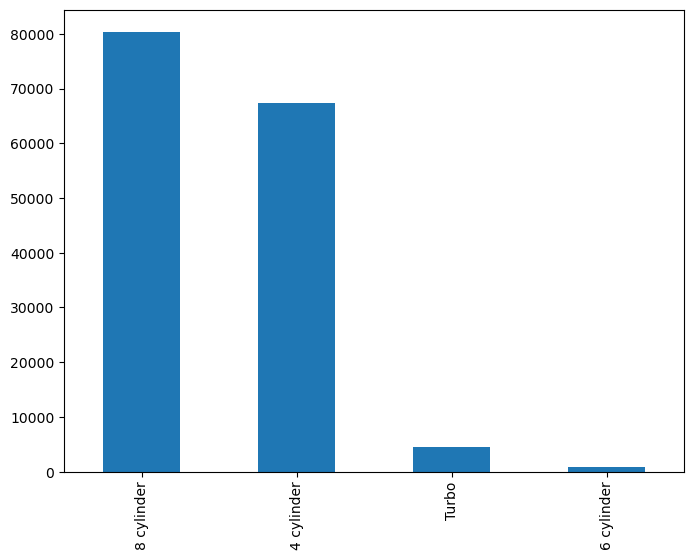

In [11]:
vc.plot(kind = 'bar', figsize=(8,6));

## Using the freq CAS action

Use the freq CAS action to get frequency values of multiple columns. The freq action returns a dictionary with a single DataFrame. The DataFrame contains the counts of unique values for each column specified.

In [12]:
## Columns to analyze
colNames = ['Engine_Model', 'Model_Year', 'Campaign_Type']

## Execute the freq CAS action and store the SASDataFrame
freq_df = tbl.freq(inputs = colNames)['Frequency']

## Display the type and DataFrame
display(type(freq_df), freq_df)

swat.dataframe.SASDataFrame

,Column,CharVar,FmtVar,Level,Frequency
0,Engine_Model,4 cylinder,4 cylinder,1,67402.0
1,Engine_Model,6 cylinder,6 cylinder,2,877.0
2,Engine_Model,8 cylinder,8 cylinder,3,80413.0
3,Engine_Model,Turbo,Turbo,4,4525.0
4,Model_Year,2015,2015,1,2546.0
5,Model_Year,2016,2016,2,32707.0
6,Model_Year,2017,2017,3,70479.0
7,Model_Year,2018,2018,4,43975.0
8,Model_Year,2019,2019,5,3510.0
9,Campaign_Type,Type 1,Type 1,1,17662.0


Loop over the DataFrame and plot the frequency values of each unique column.

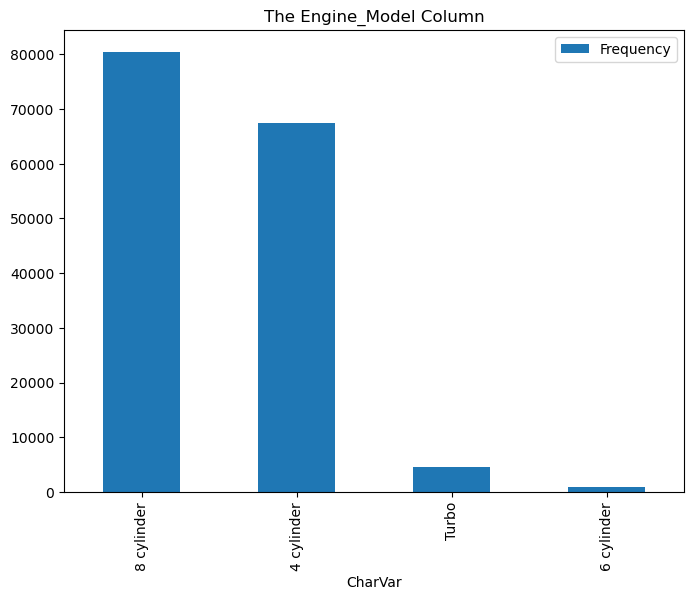

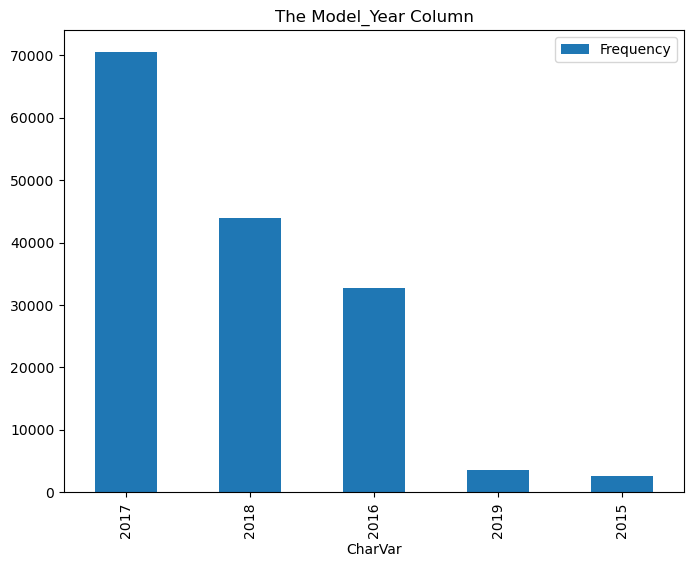

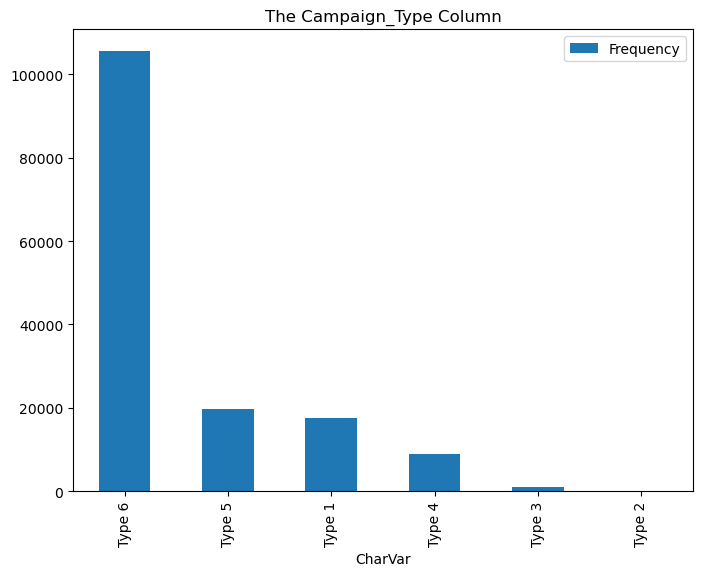

In [13]:
for column in colNames:
    (freq_df
     .query('Column == @column')
     .loc[:,['CharVar','Frequency']]
     .set_index('CharVar')
     .sort_values(by = 'Frequency', ascending=False)
     .plot(kind='bar', figsize=(8,6), title = f'The {column} Column')
    )

## Using the freqTab CAS action

Load the freqTab action set.

In [14]:
conn.loadActionSet('freqTab')

NOTE: Added action set 'freqTab'.


[actionset]

 'freqTab'

+ Elapsed: 0.0131s, user: 0.00692s, sys: 0.028s, mem: 1.07mb

Use the freqTab action to perform frequency and crosstabulation analysis.

In [15]:
tbl.freqTab(tabulate = [
                'Model_Year',
                'Engine_Model',
                {'vars':['Engine_Model','Model_Year']}
            ]
    )

[LevelInfo]

 Variable Level Information
 
        Variable         Label  Levels                                  Values
 0  Engine_Model  Engine Model       4  4 cylinder 6 cylinder 8 cylinder Turbo
 1    Model_Year    Model Year       5                2015 2016 2017 2018 2019

[NObs]

 Number of Observations
 
       RowId                  Description     Value
 0     NREAD  Number of Observations Read  153217.0
 1     NUSED  Number of Observations Used  153217.0
 2  NWEIGHTS               Sum of Weights  153217.0

[Table1.OneWayFreqs]

 Model Year
 
   F_Model_Year Model_Year  Frequency    Percent  CumFrequency  CumPercent
 0         2015       2015     2546.0   1.661696        2546.0    1.661696
 1         2016       2016    32707.0  21.346848       35253.0   23.008543
 2         2017       2017    70479.0  45.999465      105732.0   69.008008
 3         2018       2018    43975.0  28.701123      149707.0   97.709131
 4         2019       2019     3510.0   2.290869      153217.0  100.000000

[Table2.OneWayFreqs]

 Engine Model
 
   F_Engine_Model Engine_Model  Frequency    Percent  CumFrequency  CumPercent
 0     4 cylinder   4 cylinder    67402.0  43.991202       67402.0   43.991202
 1     6 cylinder   6 cylinder      877.0   0.572391       68279.0   44.563593
 2     8 cylinder   8 cylinder    80413.0  52.483080      148692.0   97.046672
 3          Turbo        Turbo     4525.0   2.953328      153217.0  100.000000

[Table3.CrossList]

 Table of Engine_Model by Model_Year
 
    F_Engine_Model Engine_Model F_Model_Year Model_Year  Frequency     Percent  RowPercent  ColPercent
 0      4 cylinder   4 cylinder         2015       2015      675.0    0.440552    1.001454   26.512176
 1      4 cylinder   4 cylinder         2016       2016    18408.0   12.014333   27.310762   56.281530
 2      4 cylinder   4 cylinder         2017       2017    28606.0   18.670252   42.440877   40.587977
 3      4 cylinder   4 cylinder         2018       2018    18461.0   12.048924   27.389395   41.980671
 4      4 cylinder   4 cylinder         2019       2019     1252.0    0.817142    1.857512   35.669516
 5      4 cylinder   4 cylinder        Total               67402.0   43.991202  100.000000         NaN
 6      6 cylinder   6 cylinder         2015       2015      665.0    0.434025   75.826682   26.119403
 7      6 cylinder   6 cylinder         2016       2016      212.0    0.138366   24.173318    0.648179
 8      6 cylinder   6 cylinder        Total                 877.0    0.572391  100.000000         NaN
 9      8 cylinder   8 cylinder         2015       2015     1180.0    0.770150    1.467424   46.347211
 10     8 cylinder   8 cylinder         2016       2016    13666.0    8.919376   16.994765   41.783105
 11     8 cylinder   8 cylinder         2017       2017    40438.0   26.392633   50.287889   57.375956
 12     8 cylinder   8 cylinder         2018       2018    23375.0   15.256140   29.068683   53.155202
 13     8 cylinder   8 cylinder         2019       2019     1754.0    1.144782    2.181239   49.971510
 14     8 cylinder   8 cylinder        Total               80413.0   52.483080  100.000000         NaN
 15          Turbo        Turbo         2015       2015       26.0    0.016969    0.574586    1.021210
 16          Turbo        Turbo         2016       2016      421.0    0.274774    9.303867    1.287186
 17          Turbo        Turbo         2017       2017     1435.0    0.936580   31.712707    2.036067
 18          Turbo        Turbo         2018       2018     2139.0    1.396059   47.270718    4.864127
 19          Turbo        Turbo         2019       2019      504.0    0.328945   11.138122   14.358974
 20          Turbo        Turbo        Total                4525.0    2.953328  100.000000         NaN
 21          Total                      2015       2015     2546.0    1.661696         NaN  100.000000
 22          Total                      2016       2016    32707.0   21.346848         NaN  100.000000
 23          Total      

## Terminate the CAS Connection

In [16]:
conn.terminate()